### Configurations and Libraries



In [307]:
# TODO: change from mounting drive to local files
# TODO: add tests

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from numpy.typing import NDArray
import seaborn as sns
import seaborn_image as isns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from generator import RegionETGenerator
import time

In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

### Load & Describe Data

In [5]:
data_path = Path('data')
model_path = Path('model')

In [6]:
images = np.load(data_path / 'images.npy')
labels = np.load(data_path / 'labels.npy')

In [6]:
print(f"Data type of images: {images.dtype}")
print(f"Data type of labels: {labels.dtype}")

Data type of images: float64
Data type of labels: int64


In [313]:
# TODO: can we keep generic? what if it's a string?
def labels_description(data: NDArray[np.int64]) -> None:
  df = pd.DataFrame(data)
  print(df.describe())
  print(df.info())

def slice_description(data: NDArray[np.float64]) -> None:
  slice = data[0, :, :].reshape(256,)
  df = pd.DataFrame(slice)
  print(df.describe())
  print(df.info())

In [63]:
slice_description(images)

                0
count  256.000000
mean     0.955877
std      0.908362
min      0.007223
25%      0.306411
50%      0.691741
75%      1.343379
max      6.263326
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       256 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB
None


In [64]:
labels_description(labels)

                0
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB
None


In [7]:
images_train_val, images_test, labels_train_val, labels_test = train_test_split(
    images, labels, test_size=0.2, random_state=42,)
images_train, images_val, labels_train, labels_val = train_test_split(
    images_train_val, labels_train_val, test_size=0.2, random_state=42,)

### Data Visualization

In [315]:
# TODO: check the type of pixels
def print_random_image(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  plt.imshow(images[index])
  plt.title(f'Label: {labels[index]}')
  plt.show()

def print_image_distribution(images: NDArray[np.float64], labels: NDArray[np.int64]) -> None:
  index = np.random.randint(0, images.shape[0])
  ax = isns.imghist(images[index])
  plt.title(f'Index: {index}, Label: {labels[index]}')

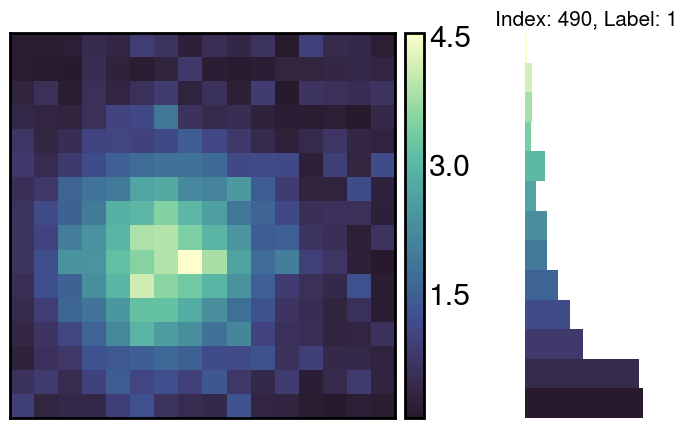

In [316]:
# TODO: histogram of pixel intensities using seaborn (or alternatives)
print_image_distribution(images, labels)

### Separate Positive and Negative Labels

In [203]:
X_train = [img for img, label in zip(images_train, labels_train) if label == 0]
y_train = [label for label in labels_train if label == 0]
# keep the outliers in the training since they will join the training set for the student
outlier_train = [img for img, label in zip(images_train, labels_train) if label == 1]
outlier_train_labels = [label for label in labels_train if label == 1]

In [205]:
len(X_train), len(y_train), len(outlier_train), len(outlier_train_labels), len(images_train)

(317, 317, 323, 323, 640)

In [206]:
X_val = [img for img, label in zip(images_val, labels_val) if label == 0]
y_val = [label for label in labels_val if label == 0]
outlier_val = [img for img, label in zip(images_val, labels_val) if label == 1]
outlier_val_labels = [label for label in labels_val if label == 1]

In [207]:
len(X_val), len(y_val), len(outlier_val), len(outlier_val_labels), len(images_val)

(86, 86, 74, 74, 160)

### (Tentative) Data Augmentation

In [127]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip horizontally and vertically
    #tf.keras.layers.RandomRotation(0.3),  # Rotate up to 20%
    #tf.keras.layers.RandomZoom(0.3),  # Zoom up to 20%
])

In [128]:
augmented_images = []
for image in X_train:
    for _ in range(4):
        augmented = data_augmentation(tf.expand_dims(image, axis=0))
        augmented_images.append(tf.squeeze(augmented).numpy())
X_train_aug = np.array(augmented_images)
y_train_aug = np.repeat(y_train, 100)

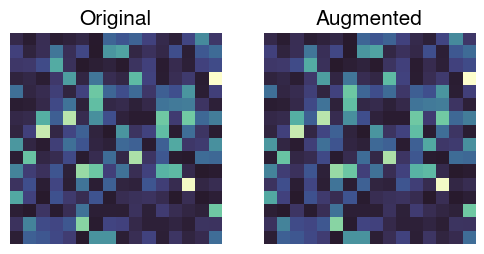

In [132]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(X_train[0])
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Augmented")
plt.imshow(X_train_aug[3])
plt.axis("off")


plt.show()

### Provided Model's Predictions

In [226]:
def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record the start time
        result = func(*args, **kwargs)  # Call the original function
        end_time = time.time()  # Record the end time
        execution_time = end_time - start_time  # Calculate the execution time
        print(f"Execution time of {func.__name__}: {execution_time:.4f} seconds")
        return result  # Return the result of the function
    return wrapper

In [227]:
# TODO: again be coherent with the same format, especially if we consider quantization
# TODO: move in utils.py
@timer_decorator
def predict(images: NDArray[np.float64]) -> NDArray[np.float32]:
  output = infer(images)
  return output

def normalize_matrix(matrix: NDArray[np.float32]) -> NDArray[np.float32]:
  min_score = np.min(matrix)
  max_score = np.max(matrix)
  normalized_output = []
  for score in matrix:
    normalized_output.append((score - min_score)/(max_score-min_score))
  return np.array(normalized_output)

In [228]:
def plot_roc_curve(labs: NDArray[np.int32], preds: NDArray[np.float32]) -> None:
  fpr, tpr, thresholds = roc_curve(labs, preds)
  roc_auc = auc(fpr, tpr)
  # Plotting the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line (random classifier)

  # Add labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")

  # Show plot
  plt.show()

In [272]:
#keras_model = tf.keras.models.load_model('model')
#keras_model = tf.keras.layers.TFSMLayer(model_path, call_endpoint = 'serving_default')ù
model = tf.saved_model.load(model_path)
infer = model.signatures['serving_default']
input_tensor = tf.convert_to_tensor(images_train, dtype=tf.float32)

Execution time of predict: 0.0012 seconds


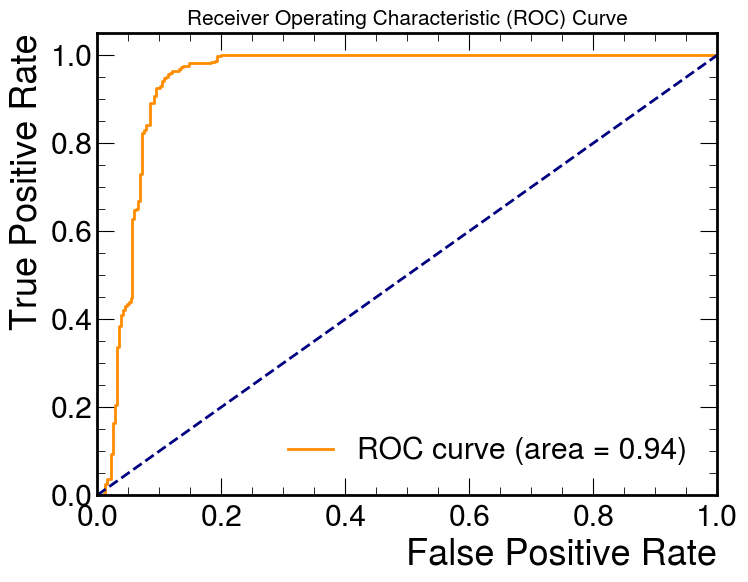

In [274]:
output = predict(input_tensor)
output = output['lambda'].numpy()
normalized_output = normalize_matrix(output)
plot_roc_curve(labels_train, normalized_output)
# idea: also add MSE 

### Proposed Model

In [114]:
from qkeras import QActivation, QConv2D, QDense, QDenseBatchnorm, quantized_bits
from tensorflow import keras, data
from keras.models import Model, load_model
from keras.layers import (
    Activation,
    AveragePooling2D,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Reshape,
    UpSampling2D,
    Conv2DTranspose
)
import numpy.typing as npt
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [184]:
from tensorflow.keras import layers, Model

class TeacherAutoencoder:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="teacher_inputs_")
        x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
        p1 = layers.MaxPooling2D((2, 2))(x1)

        x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
        x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
        p2 = layers.MaxPooling2D((2, 2))(x2)

        # Bottleneck
        b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
        b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(b)

        # Decoder
        u1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b)
        u1 = layers.concatenate([u1, x2])
        u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
        u1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

        u2 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u1)
        u2 = layers.concatenate([u2, x1])
        u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
        u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
        outputs = Conv2D(
            1,
            (3, 3),
            activation="relu",
            strides=1,
            padding="same",
            name="teacher_outputs",
        )(u2)
        return Model(inputs, outputs, name="teacher")

class TeacherAutoencoderRevised:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape
    # TODO: regularization techniques, learning-rate schedulers, batch_normalization
    def get_model(self):
        inputs = Input(shape=self.input_shape, name="teacher_inputs_")
        x = Reshape((16, 16, 1), name="teacher_reshape")(inputs)
        x = Conv2D(20, (3, 3), strides=1, padding="same", name="teacher_conv2d_1")(x)
        x = Activation("relu", name="teacher_relu_1")(x)
        x = AveragePooling2D((2, 2), name="teacher_pool_1")(x)
        x = Conv2D(30, (3, 3), strides=1, padding="same", name="teacher_conv2d_2")(x)
        x = Activation("relu", name="teacher_relu_2")(x)
        x = Flatten(name="teacher_flatten")(x)
        x = Dense(80, activation="relu", name="teacher_latent")(x)
        x = Dense(8 * 8 * 30, name="teacher_dense")(x)
        x = Reshape((8, 8, 30), name="teacher_reshape2")(x)
        x = Activation("relu", name="teacher_relu_3")(x)
        x = Conv2D(30, (3, 3), strides=1, padding="same", name="teacher_conv2d_3")(x)
        x = Activation("relu", name="teacher_relu_4")(x)
        x = Conv2DTranspose(30, (3, 3), strides=2, padding="same", name="teacher_conv_transpose")(x)
        x = Conv2D(20, (3, 3), strides=1, padding="same", name="teacher_conv2d_4")(x)
        x = Activation("relu", name="teacher_relu_5")(x)
        outputs = Conv2D(
            1,
            (3, 3),
            activation="relu",
            strides=1,
            padding="same",
            name="teacher_outputs",
        )(x)
        return Model(inputs, outputs, name="teacher-transpose")


class CicadaV2:
    def __init__(self, input_shape: tuple):
        self.input_shape = input_shape

    def get_model(self):
        inputs = Input(shape=self.input_shape, name="inputs_")
        x = Reshape((16, 16, 1), name="reshape")(inputs)
        # quantized_bits takes the following arguments:
        # total number of bits used to represent each weight value
        # number of bits used to represent the integer part
        # 1 bit if signed
        # scaling factor, 1.0 means no scaling
        x = QConv2D(
            4,
            (2, 2),
            strides=2,
            padding="valid",
            use_bias=False,
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            name="conv",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu0")(x)
        x = Flatten(name="flatten")(x)
        x = Dropout(1 / 9)(x)
        x = QDenseBatchnorm(
            16,
            kernel_quantizer=quantized_bits(8, 1, 1, alpha=1.0),
            bias_quantizer=quantized_bits(8, 3, 1, alpha=1.0),
            name="dense1",
        )(x)
        x = QActivation("quantized_relu(10, 6)", name="relu1")(x)
        x = Dropout(1 / 8)(x)
        x = QDense(
            1, # single output unit
            kernel_quantizer=quantized_bits(12, 3, 1, alpha=1.0),
            use_bias=False,
            name="dense2",
        )(x)
        outputs = QActivation("quantized_relu(16, 8)", name="outputs")(x)
        return Model(inputs, outputs, name="cicada-v2")


In [ ]:
def loss(y_true: npt.NDArray, y_pred: npt.NDArray) -> npt.NDArray:
    return np.mean((y_true - y_pred) ** 2, axis=(1, 2, 3))

def quantize(arr: npt.NDArray, precision: tuple = (16, 8)) -> npt.NDArray:
    # word contains the number of bits, int_ #bits for the integer part then 
    # calculates the number of bits for the decimal part and the step size
    # next the function calculates the maximum value that can be represented
    # finally it quantizes the array and clips the values to the maximum and 0
    word, int_ = precision 
    decimal = word - int_
    step = 1 / 2**decimal
    max_ = 2**int_ - step
    arrq = step * np.round(arr / step)
    arrc = np.clip(arrq, 0, max_)
    return arrc

def train_model(
    model: Model,
    training_dataset: data.Dataset,
    validation_dataset: data.Dataset,
    epoch: int = 1,
    steps: int = 1,
    callbacks=None,
    verbose: bool = False,
) -> None:
    model.fit(
        training_dataset,
        steps_per_epoch=len(training_dataset), # the model process the entire dataset
        initial_epoch=epoch,
        epochs=epoch + steps,
        validation_data=validation_dataset,
        callbacks=callbacks,
        verbose=verbose,
    )


In [247]:
teacher = TeacherAutoencoder((16, 16, 1)).get_model()
teacher.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
#t_mc = ModelCheckpoint(f"models/{teacher.name}", save_best_only=True)
#t_log = CSVLogger(f"models/{teacher.name}/training.log", append=True)

cicada_v2 = CicadaV2((256,)).get_model()
cicada_v2.compile(optimizer=Adam(learning_rate=0.001), loss="mae")
#cv2_mc = ModelCheckpoint(f"models/{cicada_v2.name}", save_best_only=True)
#cv2_log = CSVLogger(f"models/{cicada_v2.name}/training.log", append=True)

In [246]:
gen = RegionETGenerator()
gen_train = gen.get_generator(X_train_aug, X_train_aug, 512, True)
gen_val = gen.get_generator(X_val, X_val, 512, False)
X_train_student = np.concatenate([X_train_aug, outlier_train])
X_val_student = np.concatenate([X_val, outlier_val])

In [245]:
def get_student_targets(
    teacher: Model, gen: RegionETGenerator, X: npt.NDArray
) -> data.Dataset:
    X = np.expand_dims(X, axis=-1)
    X_hat = teacher.predict(X, batch_size=512, verbose=0)
    y = loss(X, X_hat) # FP32 loss
    y = quantize(y)
    #y = quantize(np.log(y) * 32)  # Scaled FP32 loss
    # arguments: input of the teacher model, quantized loss and batch size
    return gen.get_generator(X.reshape((-1, 256, 1)), y, 128, False)

In [248]:
for epoch in range(10):
    train_model(
        teacher,
        gen_train,
        gen_val,
        epoch=epoch,
        #callbacks=[t_mc, t_log],
        verbose=1,
    )
    tmp_teacher = load_model(f"models/{teacher.name}")
    #s_gen_train = get_student_targets(tmp_teacher, gen, X_train_student)
    #s_gen_val = get_student_targets(tmp_teacher, gen, X_val_student)

    s_gen_train = get_student_targets(tmp_teacher, gen, X_train_student)
    s_gen_val = get_student_targets(tmp_teacher, gen, X_val_student)
    train_model(
            cicada_v2,
            s_gen_train,
            s_gen_val,
            epoch=10 * epoch,
            steps=10,
            #callbacks=[cv2_mc, cv2_log],
            verbose=1,
        )

2/2 [==============================] - 1s 345ms/step - loss: 1.7829 - val_loss: 1.2981


Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 0.5467 - val_loss: 0.4461
Epoch 2/10
13/13 [==============================] - 0s 1ms/step - loss: 0.5145 - val_loss: 0.4387
Epoch 3/10
13/13 [==============================] - 0s 1ms/step - loss: 0.5024 - val_loss: 0.4444
Epoch 4/10
13/13 [==============================] - 0s 1ms/step - loss: 0.4828 - val_loss: 0.4059
Epoch 5/10
13/13 [==============================] - 0s 1ms/step - loss: 0.4777 - val_loss: 0.3815
Epoch 6/10
13/13 [==============================] - 0s 1ms/step - loss: 0.4577 - val_loss: 0.3958
Epoch 7/10
13/13 [==============================] - 0s 1ms/step - loss: 0.4351 - val_loss: 0.3655
Epoch 8/10
13/13 [==============================] - 0s 1ms/step - loss: 0.4202 - val_loss: 0.3723
Epoch 9/10
13/13 [==============================] - 0s 1ms/step - loss: 0.4029 - val_loss: 0.3400
Epoch 10/10
13/13 [==============================] - 0s 1ms/step - loss: 0.3869 - val_loss: 0.3408
Epoch 2/2
2/2 [====

Epoch 11/20
13/13 [==============================] - 0s 2ms/step - loss: 0.3627 - val_loss: 0.2965
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3589 - val_loss: 0.2776
Epoch 13/20
13/13 [==============================] - 0s 1ms/step - loss: 0.3248 - val_loss: 0.2655
Epoch 14/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2999 - val_loss: 0.2520
Epoch 15/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2871 - val_loss: 0.2364
Epoch 16/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2795 - val_loss: 0.2284
Epoch 17/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2764 - val_loss: 0.2063
Epoch 18/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2615 - val_loss: 0.1834
Epoch 19/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2518 - val_loss: 0.1874
Epoch 20/20
13/13 [==============================] - 0s 1ms/step - loss: 0.2309 - val_loss: 0.1817
Epoch 3/3


Epoch 21/30
13/13 [==============================] - 0s 2ms/step - loss: 0.2287 - val_loss: 0.1783
Epoch 22/30
13/13 [==============================] - 0s 1ms/step - loss: 0.2204 - val_loss: 0.1677
Epoch 23/30
13/13 [==============================] - 0s 1ms/step - loss: 0.2143 - val_loss: 0.1613
Epoch 24/30
13/13 [==============================] - 0s 1ms/step - loss: 0.2079 - val_loss: 0.1573
Epoch 25/30
13/13 [==============================] - 0s 1ms/step - loss: 0.2016 - val_loss: 0.1502
Epoch 26/30
13/13 [==============================] - 0s 1ms/step - loss: 0.1915 - val_loss: 0.1566
Epoch 27/30
13/13 [==============================] - 0s 1ms/step - loss: 0.1944 - val_loss: 0.1448
Epoch 28/30
13/13 [==============================] - 0s 1ms/step - loss: 0.1798 - val_loss: 0.1455
Epoch 29/30
13/13 [==============================] - 0s 2ms/step - loss: 0.1803 - val_loss: 0.1358
Epoch 30/30
13/13 [==============================] - 0s 1ms/step - loss: 0.1808 - val_loss: 0.1325
Epoch 4/4


Epoch 31/40
13/13 [==============================] - 0s 2ms/step - loss: 0.1698 - val_loss: 0.1237
Epoch 32/40
13/13 [==============================] - 0s 1ms/step - loss: 0.1588 - val_loss: 0.1216
Epoch 33/40
13/13 [==============================] - 0s 1ms/step - loss: 0.1604 - val_loss: 0.1187
Epoch 34/40
13/13 [==============================] - 0s 2ms/step - loss: 0.1603 - val_loss: 0.1175
Epoch 35/40
13/13 [==============================] - 0s 1ms/step - loss: 0.1631 - val_loss: 0.1120
Epoch 36/40
13/13 [==============================] - 0s 1ms/step - loss: 0.1583 - val_loss: 0.1140
Epoch 37/40
13/13 [==============================] - 0s 1ms/step - loss: 0.1496 - val_loss: 0.1127
Epoch 38/40
13/13 [==============================] - 0s 1ms/step - loss: 0.1473 - val_loss: 0.1100
Epoch 39/40
13/13 [==============================] - 0s 1ms/step - loss: 0.1535 - val_loss: 0.1106
Epoch 40/40
13/13 [==============================] - 0s 1ms/step - loss: 0.1420 - val_loss: 0.1134
Epoch 5/5


Epoch 41/50
13/13 [==============================] - 0s 2ms/step - loss: 0.1453 - val_loss: 0.1166
Epoch 42/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1439 - val_loss: 0.1127
Epoch 43/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1416 - val_loss: 0.1143
Epoch 44/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1445 - val_loss: 0.1108
Epoch 45/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1421 - val_loss: 0.1059
Epoch 46/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1385 - val_loss: 0.1072
Epoch 47/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1414 - val_loss: 0.1066
Epoch 48/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1375 - val_loss: 0.1065
Epoch 49/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1387 - val_loss: 0.1097
Epoch 50/50
13/13 [==============================] - 0s 1ms/step - loss: 0.1424 - val_loss: 0.1150
Epoch 6/6


Epoch 51/60
13/13 [==============================] - 0s 2ms/step - loss: 0.1393 - val_loss: 0.1114
Epoch 52/60
13/13 [==============================] - 0s 1ms/step - loss: 0.1356 - val_loss: 0.1135
Epoch 53/60
13/13 [==============================] - 0s 1ms/step - loss: 0.1399 - val_loss: 0.1157
Epoch 54/60
13/13 [==============================] - 0s 1ms/step - loss: 0.1421 - val_loss: 0.1062
Epoch 55/60
13/13 [==============================] - 0s 1ms/step - loss: 0.1393 - val_loss: 0.1157
Epoch 56/60
13/13 [==============================] - 0s 2ms/step - loss: 0.1330 - val_loss: 0.1061
Epoch 57/60
13/13 [==============================] - 0s 1ms/step - loss: 0.1346 - val_loss: 0.1050
Epoch 58/60
13/13 [==============================] - 0s 1ms/step - loss: 0.1366 - val_loss: 0.1042
Epoch 59/60
13/13 [==============================] - 0s 1ms/step - loss: 0.1287 - val_loss: 0.1145
Epoch 60/60
13/13 [==============================] - 0s 1ms/step - loss: 0.1311 - val_loss: 0.0959
Epoch 7/7


Epoch 61/70
13/13 [==============================] - 0s 2ms/step - loss: 0.1319 - val_loss: 0.0978
Epoch 62/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1315 - val_loss: 0.0959
Epoch 63/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1327 - val_loss: 0.0959
Epoch 64/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1294 - val_loss: 0.0899
Epoch 65/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1258 - val_loss: 0.0965
Epoch 66/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1295 - val_loss: 0.0969
Epoch 67/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1260 - val_loss: 0.0945
Epoch 68/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1232 - val_loss: 0.1126
Epoch 69/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1254 - val_loss: 0.1164
Epoch 70/70
13/13 [==============================] - 0s 1ms/step - loss: 0.1278 - val_loss: 0.1042
Epoch 8/8


Epoch 71/80
13/13 [==============================] - 0s 2ms/step - loss: 0.1208 - val_loss: 0.0982
Epoch 72/80
13/13 [==============================] - 0s 1ms/step - loss: 0.1238 - val_loss: 0.0942
Epoch 73/80
13/13 [==============================] - 0s 1ms/step - loss: 0.1199 - val_loss: 0.1030
Epoch 74/80
13/13 [==============================] - 0s 1ms/step - loss: 0.1227 - val_loss: 0.0963
Epoch 75/80
13/13 [==============================] - 0s 1ms/step - loss: 0.1214 - val_loss: 0.0979
Epoch 76/80
13/13 [==============================] - 0s 1ms/step - loss: 0.1210 - val_loss: 0.0932
Epoch 77/80
13/13 [==============================] - 0s 1ms/step - loss: 0.1241 - val_loss: 0.0944
Epoch 78/80
13/13 [==============================] - 0s 3ms/step - loss: 0.1202 - val_loss: 0.0951
Epoch 79/80
13/13 [==============================] - 0s 1ms/step - loss: 0.1187 - val_loss: 0.0993
Epoch 80/80
13/13 [==============================] - 0s 1ms/step - loss: 0.1211 - val_loss: 0.1031
Epoch 9/9


Epoch 81/90
13/13 [==============================] - 0s 2ms/step - loss: 0.1219 - val_loss: 0.1073
Epoch 82/90
13/13 [==============================] - 0s 1ms/step - loss: 0.1194 - val_loss: 0.0969
Epoch 83/90
13/13 [==============================] - 0s 1ms/step - loss: 0.1249 - val_loss: 0.0920
Epoch 84/90
13/13 [==============================] - 0s 1ms/step - loss: 0.1209 - val_loss: 0.0983
Epoch 85/90
13/13 [==============================] - 0s 2ms/step - loss: 0.1216 - val_loss: 0.0956
Epoch 86/90
13/13 [==============================] - 0s 1ms/step - loss: 0.1190 - val_loss: 0.0917
Epoch 87/90
13/13 [==============================] - 0s 1ms/step - loss: 0.1181 - val_loss: 0.0946
Epoch 88/90
13/13 [==============================] - 0s 1ms/step - loss: 0.1134 - val_loss: 0.0954
Epoch 89/90
13/13 [==============================] - 0s 1ms/step - loss: 0.1148 - val_loss: 0.0971
Epoch 90/90
13/13 [==============================] - 0s 1ms/step - loss: 0.1176 - val_loss: 0.1062
Epoch 10/1

Epoch 91/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1215 - val_loss: 0.0861
Epoch 92/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1152 - val_loss: 0.1057
Epoch 93/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1179 - val_loss: 0.0928
Epoch 94/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1181 - val_loss: 0.0921
Epoch 95/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1149 - val_loss: 0.0924
Epoch 96/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1171 - val_loss: 0.0885
Epoch 97/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1179 - val_loss: 0.0900
Epoch 98/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1135 - val_loss: 0.0964
Epoch 99/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1154 - val_loss: 0.0866
Epoch 100/100
13/13 [==============================] - 0s 1ms/step - loss: 0.1121 - val_loss: 0.0820

In [249]:
import importlib
import drawing
importlib.reload(drawing)
from drawing import Draw
draw = Draw(output_dir='plots', interactive=False)

In [250]:
index = 14
# Extract a single example from the augmented training set
image_example = X_train[index][np.newaxis, ...]

# Get the model's prediction
y_pred = teacher.predict(image_example)

# Calculate the error
error = loss(X_train[index][..., np.newaxis], y_pred)
print(error)

# Plot the reconstruction results
draw.plot_reconstruction_results(
    X_train[index],
    y_pred,
    loss=error[0],
    name="comparison-background",
)


1/1 [==============================] - 0s 52ms/step
[0.24904826]


In [232]:
index = 50
# Extract a single example from the augmented training set
image_example = X_val[index].astype(np.float32)[np.newaxis, ...]

# Get the model's prediction
y_pred = teacher.predict(image_example)

# Calculate the error
error = loss(X_val[index][..., np.newaxis], y_pred)

# Plot the reconstruction results
draw.plot_reconstruction_results(
    X_val[index],
    y_pred,
    loss=error[0],
    name="comparison-background",
)

1/1 [==============================] - 0s 10ms/step


In [251]:
y_pred_teacher = teacher.predict(images_test, verbose=1)
y_loss_teacher = loss(images_test[:, :, :, None], y_pred_teacher)
y_loss_cicada = cicada_v2.predict(images_test.reshape((-1, 256)), verbose=1)

7/7 [==============================] - 0s 630us/step


In [253]:
def plot_roc_curve(labs: NDArray[np.int32], preds: NDArray[np.float32]) -> None:
  fpr, tpr, thresholds = roc_curve(labs, preds)
  roc_auc = auc(fpr, tpr)
  # Plotting the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line (random classifier)

  # Add labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")

  # Show plot
  plt.show()

In [255]:
y_loss_cicada.resize((len(y_loss_cicada),))

In [262]:
for couple in zip(y_loss_cicada, labels_test):
    print(couple)

(0.6796875, 0)
(0.765625, 0)
(0.67578125, 0)
(0.16015625, 1)
(0.01953125, 1)
(0.0, 1)
(0.8203125, 0)
(0.57421875, 0)
(0.55859375, 0)
(0.0, 1)
(0.078125, 1)
(0.06640625, 1)
(0.0, 1)
(0.51953125, 0)
(0.0, 1)
(0.80078125, 0)
(0.0, 1)
(0.0, 1)
(0.5703125, 0)
(0.0, 1)
(0.67578125, 0)
(0.17578125, 1)
(0.0, 1)
(0.0, 1)
(0.73828125, 0)
(0.546875, 0)
(0.70703125, 0)
(0.0, 1)
(0.703125, 0)
(0.578125, 0)
(0.5078125, 0)
(0.66796875, 0)
(0.6796875, 0)
(0.0, 1)
(0.875, 0)
(0.0, 1)
(0.04296875, 1)
(0.62890625, 0)
(0.4375, 0)
(0.66015625, 0)
(0.0, 1)
(0.0, 1)
(0.06640625, 1)
(0.67578125, 0)
(0.0, 1)
(0.05078125, 1)
(0.015625, 1)
(0.0, 1)
(0.625, 0)
(0.0, 1)
(0.10546875, 1)
(0.0, 1)
(0.8125, 0)
(0.53515625, 0)
(0.19921875, 1)
(0.0, 1)
(0.7578125, 0)
(0.63671875, 0)
(0.56640625, 0)
(0.765625, 0)
(0.03125, 1)
(0.0, 1)
(0.0, 1)
(0.6875, 0)
(0.0, 1)
(0.0, 1)
(0.02734375, 1)
(0.64453125, 0)
(0.05859375, 1)
(0.86328125, 0)
(0.0, 1)
(0.765625, 0)
(0.0, 1)
(0.515625, 0)
(0.0, 1)
(0.0, 1)
(0.515625, 0)
(0.66406

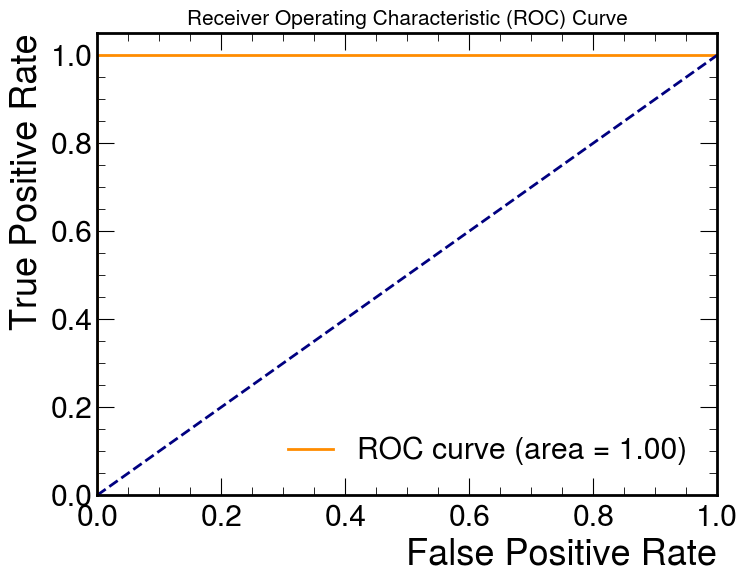

In [260]:
normalized_output = normalize_matrix(1-y_loss_cicada)
plot_roc_curve(labels_test, normalized_output)

In [261]:
for couple in zip(1-y_loss_cicada, labels_test):
    print(couple)

(0.3203125, 0)
(0.234375, 0)
(0.32421875, 0)
(0.83984375, 1)
(0.98046875, 1)
(1.0, 1)
(0.1796875, 0)
(0.42578125, 0)
(0.44140625, 0)
(1.0, 1)
(0.921875, 1)
(0.93359375, 1)
(1.0, 1)
(0.48046875, 0)
(1.0, 1)
(0.19921875, 0)
(1.0, 1)
(1.0, 1)
(0.4296875, 0)
(1.0, 1)
(0.32421875, 0)
(0.82421875, 1)
(1.0, 1)
(1.0, 1)
(0.26171875, 0)
(0.453125, 0)
(0.29296875, 0)
(1.0, 1)
(0.296875, 0)
(0.421875, 0)
(0.4921875, 0)
(0.33203125, 0)
(0.3203125, 0)
(1.0, 1)
(0.125, 0)
(1.0, 1)
(0.95703125, 1)
(0.37109375, 0)
(0.5625, 0)
(0.33984375, 0)
(1.0, 1)
(1.0, 1)
(0.93359375, 1)
(0.32421875, 0)
(1.0, 1)
(0.94921875, 1)
(0.984375, 1)
(1.0, 1)
(0.375, 0)
(1.0, 1)
(0.89453125, 1)
(1.0, 1)
(0.1875, 0)
(0.46484375, 0)
(0.80078125, 1)
(1.0, 1)
(0.2421875, 0)
(0.36328125, 0)
(0.43359375, 0)
(0.234375, 0)
(0.96875, 1)
(1.0, 1)
(1.0, 1)
(0.3125, 0)
(1.0, 1)
(1.0, 1)
(0.97265625, 1)
(0.35546875, 0)
(0.94140625, 1)
(0.13671875, 0)
(1.0, 1)
(0.234375, 0)
(1.0, 1)
(0.484375, 0)
(1.0, 1)
(1.0, 1)
(0.484375, 0)
(0.33593